In [1]:
import numpy as np
import scipy.stats as ss
from multiprocessing import Process,cpu_count,Manager
from decimal import Decimal
from sklearn.metrics import mean_squared_error as MSE
import os
from matplotlib import pyplot as plt

In [2]:
class RV:
    def __init__(self, dist_name,loc,scale):
        '''
        dist_name: 'norm' or 'uniform'
        loc, scale: the same as used in scipy.stats
        '''
        
        self.dist_name = dist_name
        self.loc = loc
        self.scale = scale
        
        if self.dist_name == 'uniform': 
            self.rvf = np.random.uniform
            self.rvf_scale = self.loc + self.scale
            self.pdf = ss.uniform.pdf
        
            
        if self.dist_name == 'normal':
            self.rvf = np.random.normal
            self.rvf_scale = self.scale
            self.pdf = ss.norm.pdf
        
    def rvfv(self):
        '''
        Generate a random sample from the given prior distribution
        '''
        return self.rvf(self.loc,self.rvf_scale)

In [3]:
class smc_abc_ours:
    def __init__(self,simulator,priors,min_epsilon,population_size,distance_function,
                 Yobs,max_iter=100,outfile=None,cores=cpu_count(),generation_size=128):
        '''
        simulator:       a function that takes a dictionary of parameters as input. Ouput {'data':Ysim}
        priors:          a dictionary which use id of parameters as keys and RV class object as values
        min_epsilon:     minimal epsilon
        population_size: the size of each population
        distance_function: a function that calculate the distance between observed data and simulated data
        Yobs:            observed data
        outfile:         unique id for the experiment. This will be also used to continue a simulation that 
                         is partly done
        cores:           number of treads
        
        !!!Important: distance is to be minimized!!!
        '''
        self.simulator = simulator
        self.priors = priors
        self.posterior = priors                   # to be updated
        self.population_size = population_size
        self.max_iter = max_iter
        self.distance_function = distance_function
        self.min_epsilon = min_epsilon
        self.Yobs = Yobs
        self.outfile = outfile
        self.population = []  # a list of populations [p1,p2...]
        self.distances = []    # a list of distances for particles in population
        self.simulations = 0  # number of simulations performed 
        self.cores = cores    
        self.simulated_data_t0 = [] # first population
        self.population_t0 = []
        self.distances_t0 = []
        self.simulated_data = []  # last population
        self.epsilons = [np.inf]          # min distance in each generation
        self.generation_size = generation_size   # number of particles to be simulated at each generation
        self.all_simulated_data = []  # store all simulated data
        self.all_particles = []       # store all simulated particles
        self.all_distances = []       # store all simulated distances
        
    
    def simulate_one(self,particle,index,Q):
        '''
        particle:  parameters 
        Q:      a multiprocessing.Queue object
        index:  the index in particles list
        '''
        res = self.simulator(particle)
        # ysim = {simulated}

        Q.put((index,res))
    
    def calculate_distances_parallel(self,particles):
        Q = Manager().Queue()
        jobs = [Process(target=self.simulate_one,args=(particle,index,Q)) 
                               for index,particle in enumerate(particles)]
        
        for p in jobs: p.start()
        for p in jobs: p.join()
        
        distances = [None for _ in range(len(particles))]
        simulated_data = [None for _ in range(len(particles))]

        for index,res in [Q.get(timeout=1) for p in jobs]: 
            distances[index] = self.distance_function(self.Yobs,res)
            simulated_data[index] = res
        
        # save all simulated results
        #self.all_simulated_data.extend(simulated_data)
        self.all_distances.extend(distances)
        #self.all_particles.extend(particles)
        
        return distances,simulated_data

    
    def check_t0_particles(self,particles):
        # check Topt < Tm, if false, resample from prior
        for particle in particles:
            for idp in particle.keys():
                if 'Tm' not in idp: continue
                id_topt = idp.split('_')[0]+'_Topt'
                if particle[idp]>particle[id_topt]: continue
                count = 0 # maximal resample times
                while count<10:
                    tm = self.posterior[idp].rvfv()
                    topt = self.posterior[id_topt].rvfv()
                    if tm>topt:
                        particle[idp] = tm
                        particle[id_topt]= topt
                        break
                    count += 1
        return particles
    
    def simulate_a_generation(self):
        particles_t, simulated_data_t, distances_t = [], [], []
        while len(particles_t) < self.generation_size:
            self.simulations += self.cores
            particles = [{idp: rv.rvfv() for idp,rv in self.posterior.items()} for i in range(self.cores)]
            particles = self.check_t0_particles(particles)
            distances,simulated_data = self.calculate_distances_parallel(particles)
            
            particles_t.extend(particles)
            simulated_data_t.extend(simulated_data)
            distances_t.extend(distances)
        
        return particles_t, simulated_data_t, distances_t
    
    def update_population(self,particles_t, simulated_data_t, distances_t):
        print ('updating population')
        # save first generation
        if len(self.population) == 0:
            self.population_t0 = particles_t
            self.distances_t0 = distances_t
            self.simulated_data_t0 = simulated_data_t
        
        
        combined_particles = np.array(self.population + particles_t)
        combined_distances = np.array(self.distances + distances_t)
        combined_simulated = np.array(self.simulated_data + simulated_data_t)
        
        sort_index = np.argsort(combined_distances)
        self.population = list(combined_particles[sort_index][:self.population_size])
        self.distances = list(combined_distances[sort_index][:self.population_size])
        self.simulated_data = list(combined_simulated[sort_index][:self.population_size])
        self.epsilons.append(np.median(self.distances))
        
        print('t{0}: epsilon='.format(len(self.epsilons)-1),str(self.epsilons[-1]))
        
        
    def update_posterior(self):
        print ('Updating prior')
        parameters = dict()   # {'Protein_Tm':[]}
        for particle in self.population:
            for p,val in particle.items(): 
                lst = parameters.get(p,[])
                lst.append(val)
                parameters[p] =lst
        
        for p, lst in parameters.items():
            self.posterior[p] = RV('normal', loc = np.mean(lst), scale = np.std(lst))
        
    
    def run_simulation(self):
        while self.epsilons[-1] > self.min_epsilon and len(self.epsilons)<self.max_iter+1:
            particles_t, simulated_data_t, distances_t = self.simulate_a_generation()
            self.update_population(particles_t, simulated_data_t, distances_t)
            self.update_posterior()
            #pickle.dump(self,open(self.outfile,'wb'))

In [4]:
def plot_params_bar(true_params,results):
    
    cols = list(true_params.keys())
    cols.sort()
    pos = np.arange(len(true_params))*3
    
    plt.figure(figsize=(10,3))
    plt.bar(pos,[true_params[col] for col in cols],label='True',zorder=1)
    
    plt.bar(pos+1,[np.median([item[col] for item in results.population]) for col in cols],label='Post',zorder=1)
    
    s = len(results.population)
    for i,col in enumerate(cols):
        plt.scatter([pos[i]]*s+np.random.normal(1,0.01,size=s),
                    [item[col] for item in results.population],
                    color='gray',alpha=0.5,s=5,zorder=2)
    plt.legend()
    plt.xlabel('Parameters')
    plt.ylabel('Values')
    plt.show()

In [5]:
def plot_training_curve(results,outname=None,logy=False):
    
    plt.figure(figsize=(3,2.6))
    plt.scatter(np.arange(len(results.epsilons)-1),results.epsilons[1:])
    
    if logy: plt.yscale('log')
    plt.xlabel('Iterations')
    plt.ylabel('Median MSE')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

### Test

In [6]:
def run_test():
    def model(param):
        # {'p0':,'p1':,...}
        p = np.array([param['p{0}'.format(i)] for i in range(len(param))])

        res = np.dot(x_exp,np.transpose(p))

        return res
    def distance(y_exp,y_pred):
   
        return MSE(y_exp,y_pred)#-np.sum((np.array(y_exp)-y_pred)**2)
    
    feat_num = 10
    training_samples = 100
    x_exp       = np.random.normal(size=(training_samples,feat_num))
    true_params = {'p{0}'.format(i): np.random.uniform() for i in range(feat_num)}
    y_exp       = model(true_params) + np.random.normal(scale=0.1,size=training_samples)
    
    priors = {'p{0}'.format(i):RV('normal',0,1) for i in range(feat_num)}
    
    exp = smc_abc_ours(model,
                   priors,
                   0,
                   population_size=100,
                   distance_function=distance,
                   Yobs=y_exp,
                   max_iter=50,
                   cores=4,
                   generation_size=128)
    
    exp.run_simulation()
    
    plot_params_bar(true_params,exp)
    
    plot_training_curve(exp)

updating population
t1: epsilon= 18.935789368135783
Updating prior
updating population
t2: epsilon= 11.130772621904464
Updating prior
updating population
t3: epsilon= 7.835865921406456
Updating prior
updating population
t4: epsilon= 5.3684011516588805
Updating prior
updating population
t5: epsilon= 3.697979564076941
Updating prior
updating population
t6: epsilon= 2.506461721146035
Updating prior
updating population
t7: epsilon= 1.8211432818951925
Updating prior
updating population
t8: epsilon= 1.2731043019548185
Updating prior
updating population
t9: epsilon= 0.8802616598150219
Updating prior
updating population
t10: epsilon= 0.5724099797501561
Updating prior
updating population
t11: epsilon= 0.36543982087281995
Updating prior
updating population
t12: epsilon= 0.25732944915290323
Updating prior
updating population
t13: epsilon= 0.18718449461204417
Updating prior
updating population
t14: epsilon= 0.13220452104171965
Updating prior
updating population
t15: epsilon= 0.08757334471365849
Up

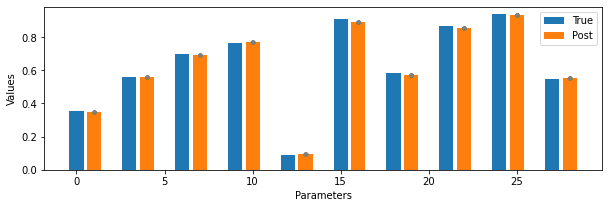

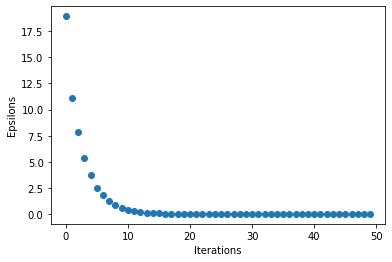

In [7]:
if __name__ == '__main__': run_test()